Model Check
=======

We're going to use our processed data files to attempt to make some predictions. First, I'll just see if running everything through a (cross-validated) random forest will actually return results.

In [3]:
%matplotlib inline

import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wcf
print(f'WCF API version {wcf.__version__}')

WCF API version 0.6.1


In [4]:
men_path = Path('data') / 'men'
women_path = Path('data') / 'women'

def combine_dataframes(start_path):
    files = os.listdir(start_path)
    frames = []
    for f in files:
        filename = start_path / f
        frames.append(pd.read_csv(filename))
    return pd.concat(frames)

women_df = combine_dataframes(women_path)
print(women_df.shape)
women_df.head()

(8248, 18)


,tourney_id,game_id,round,team_0,team_1,end_number,hammer,scored_points,scoring_team,score_diff,score_ends_diff,score_hammer_diff,score_hammer_ends_diff,steal_diff,steal_ends_diff,blanks,winning_team,year
0,371,16117,1,CHN,GER,1,0.0,0,0,0,0,0,0,0,0,1,1,2010
1,371,16117,1,CHN,GER,2,0.0,0,1,-1,-1,-1,-1,0,0,1,1,2010
2,371,16117,1,CHN,GER,3,1.0,1,3,2,0,2,0,0,0,1,1,2010
3,371,16117,1,CHN,GER,4,0.0,0,3,-1,-1,-1,-1,0,0,1,1,2010
4,371,16117,1,CHN,GER,5,1.0,0,1,-2,-2,-1,-1,-1,-1,1,1,2010


In [5]:
men_df = combine_dataframes(men_path)
print(men_df.shape)
men_df.head()

(8239, 18)


,tourney_id,game_id,round,team_0,team_1,end_number,hammer,scored_points,scoring_team,score_diff,score_ends_diff,score_hammer_diff,score_hammer_ends_diff,steal_diff,steal_ends_diff,blanks,winning_team,year
0,355,15888,1,SWE,FRA,1,0.0,0.0,0,0,0,0,0,0,0,1,1,2010
1,355,15888,1,SWE,FRA,2,0.0,1.0,1,1,1,0,0,1,1,1,1,2010
2,355,15888,1,SWE,FRA,3,0.0,1.0,1,2,2,0,0,2,2,1,1,2010
3,355,15888,1,SWE,FRA,4,0.0,0.0,0,2,2,0,0,2,2,2,1,2010
4,355,15888,1,SWE,FRA,5,0.0,1.0,2,4,3,0,0,4,3,2,1,2010


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


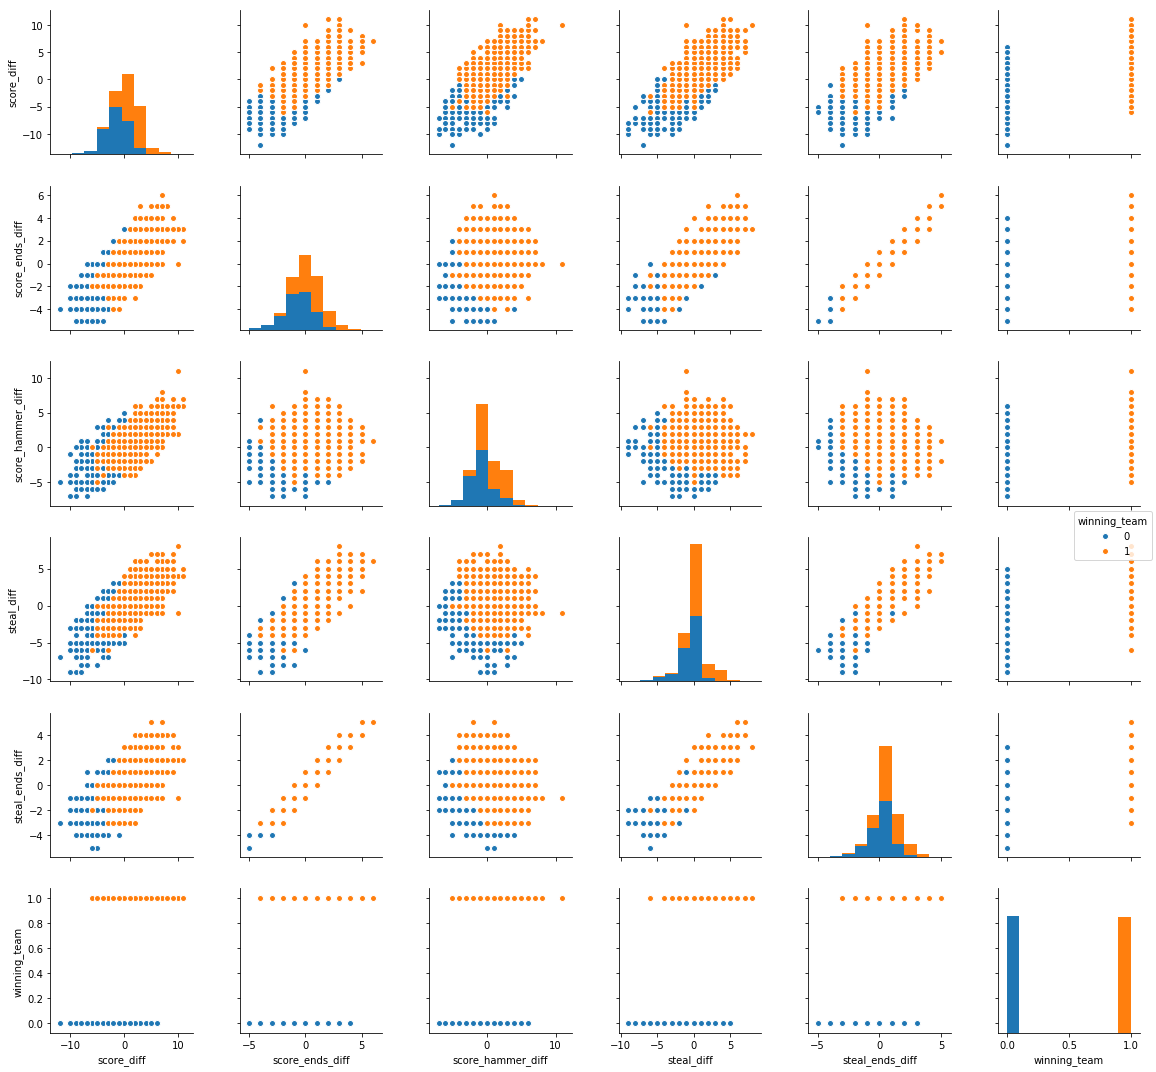

In [18]:
sns.pairplot(women_df[['score_diff',
                       'score_ends_diff',
                       'score_hammer_diff',
                       'steal_diff',
                       'steal_ends_diff',
                       'winning_team']],
             hue='winning_team')
plt.show()

It looks like we can get some separability here, but that might just be a limitation of the plot. This plot also doesn't include the country code (Canada probably would get a boost in any classifier), and I am unsure about how some of the non-diff data could help out.

What should happen is how well the model performs when given just the first end, then the first two ends, etc. Or something like that. I'll see what happens as I start testing stuff. I'll focus on just the women's games first.

Initial model check
----------------------

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

data = pd.get_dummies(women_df).dropna()

holdout = data[data.year == 2017]
training = data[data.year != 2017]

params = {'n_estimators': [10, 25, 50],
          'max_depth': [2, 5, 10, None]}

X_train = training.drop(['winning_team', 'game_id', 'tourney_id'], axis=1)
# X_train.columns
y_train = training.winning_team
X_test = training.drop(['winning_team', 'game_id', 'tourney_id'], axis=1)
y_test = training.winning_team

reg = GridSearchCV(RandomForestClassifier(),
                   params,
                   cv=3)

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.79143610013175225

In [52]:
reg.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [53]:
data_men = pd.get_dummies(men_df).dropna()
data_men['team_0_LAT'] = 0
data_men['team_1_LAT'] = 0

men_X = data_men[X_train.columns]
men_y = data_men.winning_team

reg.score(men_X, men_y)

0.75279397473275023

Feature ranking:
70: end_number (0.2035)
70: hammer (0.1725)
70: scored_points (0.1635)
70: scoring_team (0.0955)
70: score_diff (0.0889)
70: score_ends_diff (0.0290)
70: score_hammer_diff (0.0277)
70: score_hammer_ends_diff (0.0211)
70: steal_diff (0.0202)
70: steal_ends_diff (0.0191)
70: blanks (0.0130)
70: year (0.0124)
70: round_1 (0.0098)
70: round_10 (0.0096)
70: round_11 (0.0092)
70: round_12 (0.0088)
70: round_13 (0.0084)
70: round_14 (0.0076)
70: round_15 (0.0072)
70: round_16 (0.0052)
70: round_17 (0.0047)
70: round_2 (0.0045)
70: round_3 (0.0040)
70: round_4 (0.0037)
70: round_5 (0.0036)
70: round_6 (0.0034)
70: round_7 (0.0033)
70: round_8 (0.0025)
70: round_9 (0.0023)
70: round_B (0.0023)
70: round_F (0.0022)
70: round_P1 (0.0020)
70: round_P3 (0.0020)
70: round_SF (0.0019)
70: round_T1 (0.0016)
70: round_T2 (0.0016)
70: team_0_CAN (0.0015)
70: team_0_CHN (0.0014)
70: team_0_CZE (0.0014)
70: team_0_DEN (0.0013)
70: team_0_FIN (0.0013)
70: team_0_GBR (0.0012)
70: team_0_GER

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


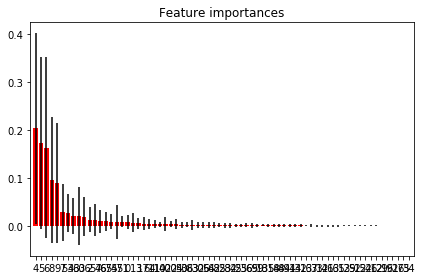

In [57]:
import numpy as np

importances = reg.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_
              for tree in reg.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
for i in range(X_train.shape[1]):
    name = X_train.columns[i]
    imp = importances[indices[i]]
    print(f'{f + 1:2d}: {name} ({imp:.4f})')

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [56]:
X_train.columns[53]

'team_1_CAN'

The team listing at the end of the feature importances somewhat makes sense, so it's nice to see that the model picks out some of the top teams automatically, which is cool. Our testing accuracy of 0.8 is pretty good. We can probably do better with some directed feature engineering (or maybe a different model), but it's good to see that I actually *can* build out a predicitive model for this.

The feature interactions (end_number x score_diff x hammer, for instance), will probably increase how good my model could become. Instead of building out those interactions automatically, I'll build them explicitly.